In [21]:
import random
import networkx as nx
import numpy as np
from tqdm import tqdm
import plotly.express as px

In [93]:
def update_belonging_factor(G, v, community_id, matrix, node_to_id_mapping):
    neighbor_factors = [matrix[node_to_id_mapping[w]][community_id] for w in G.neighbors(v)]
    return sum(neighbor_factors)/len(neighbor_factors)


def compute_value_strength_measure(G, v_i, v_j):
    v_i_neighbors = set([w for w in G.neighbors(v_i)])
    v_j_neighbors = set([w for w in G.neighbors(v_j)])
    return len(v_j_neighbors - v_i_neighbors)/len(v_j_neighbors)

def compute_state_belonging(G, v, strenght_of_value_dict):
    value_strength_vals = [val for _, val in strenght_of_value_dict[v].items()]
    s1_belonging = sum(value_strength_vals)/G.number_of_nodes()
    s0_belonging = 1 - s1_belonging
    return s0_belonging, s1_belonging

def compute_vote(v, selected_label, matrix, s0, s1):
    belonging_factor = matrix[v][selected_label]
    return s0 * belonging_factor + s1*(1-belonging_factor)/3


def CIDLPA_algorithm(G, r=0.05):
    V = list(G.nodes)
    E = list(G.edges)
    node_to_id = {v:i for i,v in enumerate(V)}
    id_to_node = {i:v for i,v in enumerate(V)}
    community_label_to_id = {str(v):i for v,i in node_to_id.items()}
    id_to_community_label = {i:str(v) for i,v in id_to_node.items()}
    n = len(V)

    # PART 1: Initialize community_belonging_matrix
    community_belonging_matrix = np.zeros(shape=(n, n))
    # node's belonging to its own community is set to 1
    for i in tqdm(range(n), desc='Part 1'):
        community_belonging_matrix[i][i] = 1


    # PART 2
    # compute strength of value of neighbors to given nodes
    neigh_strength_of_value_dict = {v:{} for v in V}
    for v in tqdm(V, desc='Part 2a'):
        v_neighbors = [w for w in G.neighbors(v)]
        for w in v_neighbors:
            measure_val = compute_value_strength_measure(G, w, v)
            neigh_strength_of_value_dict[v][w] = measure_val

    # compute belonging of each node to the two states
    s0_belonging = {}
    s1_belonging = {}
    for v in tqdm(V, desc='Part 2b'):
        s0_factor, s1_factor = compute_state_belonging(G, v, neigh_strength_of_value_dict)
        s0_belonging[v] = s0_factor
        s1_belonging[v] = s1_factor

    # PART 3
    for t in tqdm(range(5), desc='Part 3'):
        random.shuffle(V)
        for v in V:
            v_id = node_to_id[v]
            max_vote_seen = -1
            max_vote_label_id = None
            neigh_num = 0
            for w in G.neighbors(v):
                w_id = node_to_id[w]
                neigh_num += 1
                label_id = np.argmax(community_belonging_matrix[w_id])
                vote = compute_vote(w_id, label_id, community_belonging_matrix, s0_belonging[w], s1_belonging[w])
                if vote >= max_vote_seen:
                    max_vote_seen = vote
                    max_vote_label_id = label_id
            if neigh_num >0:
                assert max_vote_label_id is not None
                label_set_v = community_belonging_matrix[v_id]
                label_set_v[max_vote_label_id] = max_vote_seen
                belonging_factor_sum = np.sum(label_set_v)
                updated_label_set = label_set_v/belonging_factor_sum
                community_belonging_matrix[v_id] = updated_label_set

#     for i in tqdm(range(n), desc='filter low_r labels'):
#         for j in range(n):
#             if community_belonging_matrix[i][j] < r:
#                 community_belonging_matrix[i][j] = 0
    
    main_communities = np.argmax(community_belonging_matrix, axis=1)
    nodes_by_communities = {}
    for v in tqdm(V, desc='getting communities'):
        v_id = node_to_id[v]
        label_id = main_communities[v_id]
        community = id_to_node[label_id]
        if community not in nodes_by_communities:
            nodes_by_communities[community] = []
        nodes_by_communities[community].append(v)
        
    new_communities = {}
    for idx, item in enumerate(nodes_by_communities.items()):
        new_communities[idx] = item[1]

    
#     return new_communities#, community_belonging_matrix, node_to_id, id_to_node
    return new_communities, community_belonging_matrix

In [3]:
with open('docmap') as f:
    docMapStrings = f.read().split('\n')
    docMapStrings = list(map(lambda x : x.split('\t'), docMapStrings))
    docMap = []
    for index, line in enumerate(docMapStrings):
        docMap.append([index+1, int(line[0]), line[1]])

In [4]:
with open('pair_doc') as f:
    edgesStrings = f.read().split('\n')
    edgesStrings = list(map(lambda x : x.split(' '), edgesStrings))
    edgesStrings=  list(filter(lambda x : x != [''], edgesStrings))
    edges = []
    for line in edgesStrings:
        edges.append([int(line[0]), int(line[1])])

In [5]:
for edge in edges:
    if 0 in edge:
        print(edge)

In [6]:
directedG = nx.DiGraph()
undirectedG1 = nx.Graph()

In [7]:
for doc in docMap:
    directedG.add_node(doc[0], id=doc[1], name=doc[2])
    undirectedG1.add_node(doc[0], id=doc[1], name=doc[2])

In [8]:
edgesSeen = set()
for edge in edges:
    u = edge[0]
    v = edge[1]
    directedG.add_edge(u, v)
    if str([v, u]) in edgesSeen:
        undirectedG1.add_edge(u, v)
    else:
        edgesSeen.add(str(edge))

In [9]:
undirectedG2 = directedG.to_undirected()

In [22]:
print(directedG.number_of_edges(), undirectedG1.number_of_edges() + undirectedG2.number_of_edges())

22432 22432


In [15]:
edgesSeen = set()
undirectedG1Edges = undirectedG1.edges
undirectedG2Edges = undirectedG2.edges
for edge in directedG.edges:
    u = edge[0]
    v = edge[1]
    assert (edge in undirectedG2Edges)
    if str((v,u)) in edgesSeen:
        assert (edge in undirectedG1Edges)
    else:
        edgesSeen.add(str(edge))

In [16]:
notConnected = 0
for node in undirectedG2.nodes:
    if set() == set(undirectedG2.adj[node]):
        notConnected+= 1
print(notConnected)

5107


In [82]:
first_communities = CIDLPA_algorithm(undirectedG2)

getting communities: 100%|████████████| 14468/14468 [00:00<00:00, 704488.03it/s]


In [83]:
len(first_communities)

6597

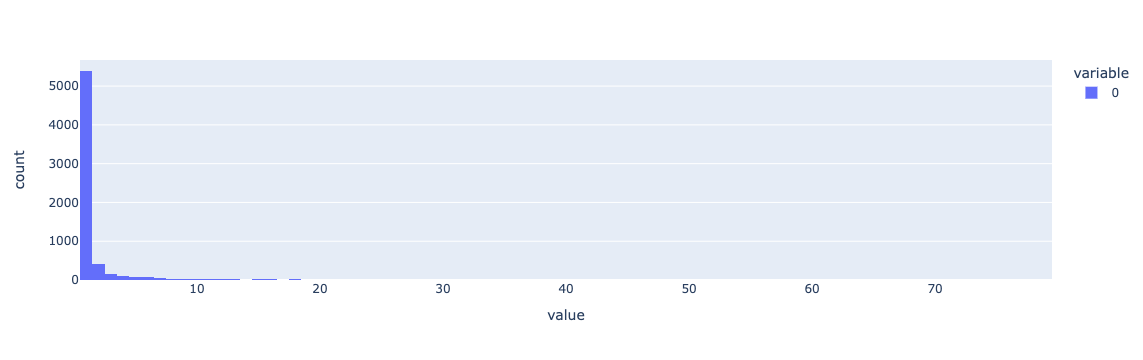

In [77]:
px.histogram([len(communities[k]) for k in communities])

In [59]:
# layers = [undirectedG2]
# curCommunities = CIDLPA_algorithm(undirectedG2)[0]
# communities = [curCommunities]

In [62]:
# layers.append(generateLayerGraph(communities[0], undirectedG2))

In [65]:
# prevLayerLength = len(list(layers[0].nodes))
# iteration = 0
# while len(communities[-1].items()) > 1 and len(communities[-1].items()) < prevLayerLength:
#     iteration += 1
#     print()
#     print(iteration)
#     prevLayerLength = len(list(layers[-1].nodes))
#     communities.append(CIDLPA_algorithm(layers[-1])[0])
#     layers.append(generateLayerGraph(communities[-1], layers[-1]))

In [84]:
def generateLayerGraph(communities, childGraph):
    graph = nx.Graph()
    keys = list(communities.keys())
    for k in keys:
        graph.add_node(k)
    length = len(keys)
    for u in tqdm(range(length-1), desc='running generateLayerGraph'):
        key1 = keys[u]
        uNodes = set(communities[key1])
        for v in range(u+1,length):
            key2 = keys[v]
            for vNode in communities[key2]:
                vNeighbors = set(childGraph.adj[vNode])
                if uNodes.intersection(vNeighbors) != set():
                    graph.add_edge(u,v)
                    break
    return graph

In [85]:
def generateTree(leafGraph, algorithm):
    layers = [leafGraph]
    curCommunities = algorithm(leafGraph)
    communities = [curCommunities]
    layers.append(generateLayerGraph(communities[0], leafGraph))
    prevLayerLength = len(list(layers[0].nodes))
    iteration = 0
    while len(communities[-1].items()) > 1 and len(communities[-1].items()) < prevLayerLength:
        iteration += 1
        print()
        print(iteration)
        prevLayerLength = len(list(layers[-1].nodes))
        communities.append(algorithm(layers[-1]))
        layers.append(generateLayerGraph(communities[-1], layers[-1]))
    
    if len(communities[-1].items()) >= prevLayerLength:
        previous_layer = layers[-2]
        last_community = {0: list(previous_layer.nodes())}
        last_layer = generateLayerGraph(last_community, previous_layer)
        tree, root = combineLayers(layers[:-1]+[last_layer], communities[:-1]+[last_community])
    
    else:
        tree, root = combineLayers(layers, communities)

    return tree, root, layers, communities

In [86]:
def combineLayers(layers, communities):
    graph = nx.DiGraph()
    n = len(layers)
    root = str((n, 0))
    graph.add_node(root)
    layers.reverse()
    communities.reverse()
    treeLayer = n
    for idx, curGraph in enumerate(layers[1:-1]):
        treeLayer = treeLayer - 1
        for node in curGraph.nodes:
            graph.add_node(str((treeLayer, node)))
            
        curCommunities= communities[idx]
        for k, v in curCommunities.items():
            for node in v:
                graph.add_edge(str((treeLayer+1, k)), str((treeLayer, node)))
    
    for node in layers[-1].nodes:
        graph.add_node(node)
  
    curCommunities = communities[-1]
    for k, v in curCommunities.items():
        for node in v:
            graph.add_edge(str((2, k)), node)

    return graph, root

In [88]:
tree, root, layers, communities = generateTree(undirectedG2, CIDLPA_algorithm)

running generateLayerGraph: 100%|██████████| 6652/6652 [00:55<00:00, 120.18it/s]



1


running generateLayerGraph: 100%|██████████| 5461/5461 [00:25<00:00, 216.84it/s]



2


running generateLayerGraph: 100%|██████████| 5315/5315 [00:22<00:00, 236.76it/s]



3


running generateLayerGraph: 100%|██████████| 5309/5309 [00:22<00:00, 234.32it/s]



4


running generateLayerGraph: 100%|██████████| 5309/5309 [00:25<00:00, 208.23it/s]
running generateLayerGraph: 0it [00:00, ?it/s]


In [105]:
potential_leaves = [n for n in tree.nodes() if len(list(tree.successors(n)))==0]
len(potential_leaves)

14468

In [98]:
tree.degree[root]

5310

In [107]:
list(tree.nodes())[-3]

14466

In [111]:
paths_exist = []
for n in tqdm(potential_leaves):
    paths_exist.append(nx.shortest_path_length(tree, source=root, target=n))

100%|███████████████████████████████████| 14468/14468 [00:12<00:00, 1181.72it/s]


In [112]:
max(paths_exist), min(paths_exist)

(5, 5)

In [113]:
import pickle

In [114]:
with open('CIDLPA_tree.pkl', 'wb') as f:
    pickle.dump(tree, f)
with open('CIDLPA_root.pkl', 'wb') as f:
    pickle.dump(root, f)